In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.sparse.linalg

from time import time

import pandas as pd

# install this with "pip install datafold"
import datafold.pcfold as pfold

from large_eigensystems import *
from test_efficiency import *

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [32]:
example = "torus" # "square"

if example == "square":
    def sensor1(_x,_y):
        return np.column_stack([
            _x,
            _y
        ])
    def sensor2(_x,_z):
        return np.column_stack([
            (1+_z+_x/4)/3 * np.cos(3*np.pi*_z),
            (1+_z+_x/4)/3 * np.sin(3*np.pi*_z)
        ])
    get_peff = None
elif example == "torus":
    def sensor1(_z,_eps):
        _z = _z+0.5
        _eps = _eps+0.5
        return np.column_stack([
            (3/2 * _eps + _z /3 + 2/3) *np.cos(4*np.pi*_eps),
            (3/2 * _eps + _z /3 + 2/3) *np.sin(4*np.pi*_eps)
        ])
    def sensor2(_z,_nu):
        _z = _z+0.5
        _nu = _nu+0.5
        return np.column_stack([
            (1+1/3*np.cos(2*np.pi*_z))*np.cos(2*np.pi*_nu),
            (1+1/3*np.cos(2*np.pi*_z))*np.sin(2*np.pi*_nu),
            1/3*np.sin(2*np.pi*_z)
        ])
    def get_peff(x,y,z): return x[:,0];# = lambda x,y,z: x

kernel_evecs = 150
cknn_k_neighbor = 25
evec_tol = 1e-4
kernel_tol = 1e-11
_te = TestEfficiency(sensor1, sensor2, n_pts=5000,
                     cknn_k_neighbor=cknn_k_neighbor, n_kernel_evecs=kernel_evecs, get_peff=get_peff,
                     evec_tol=evec_tol, kernel_tol=kernel_tol, kernel_type="cknn")


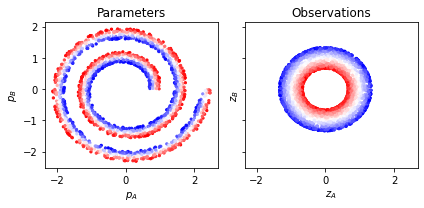

In [33]:
s1, s2, peff = _te.setup_example()

idx_plot = np.arange(0,min(s1.shape[0], 2000))
cmap1 = "winter"
cmap2 = "bwr"
m_s = 5

fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

ax[0].scatter(*s1[:,[0,1]][idx_plot,:].T, s=m_s,c=peff[idx_plot,], cmap=cmap2)
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

idx_s2 = s2[:,2] > 0
ax[1].scatter(*s2[idx_s2,:][:,[0,1]].T, s=m_s,c=peff[idx_s2,], cmap=cmap2)
ax[1].set_title("Observations");
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()
fig.savefig(f"js_efficiencytest_setup_{example}.png")

In [34]:
Cevals, Cevecs = _te.compute_common_system()

Time for kernel 1: 0.21899199485778809
Sparsity of kernel 1: 0.480464 percent
Time for kernel 2: 0.21934080123901367
Sparsity of kernel 2: 0.484912 percent
computing first eigensystem... done
computing second eigensystem... done
Time for sparse SVD 0.029150962829589844


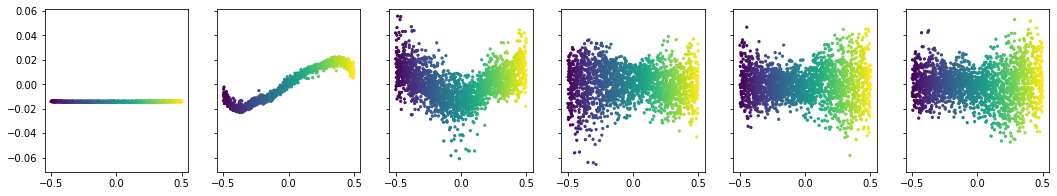

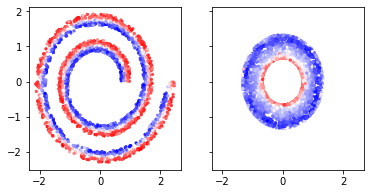

In [35]:
n_plots = 6
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*3,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(peff[idx_plot,].ravel(), Cevecs[idx_plot,k],c=peff[idx_plot,], s=5)
    
fig,ax=plt.subplots(1,2,figsize=(6,3),sharey=True, sharex=True)
ax[0].scatter(*s1[idx_plot,:].T,c=Cevecs[idx_plot,1], s=m_s, cmap=cmap2);
ax[1].scatter(*s2[idx_s2,:][:,[0,1]].T,c=Cevecs[idx_s2,1], s=m_s, cmap=cmap2);

In [36]:
_te.time_data

{'n_pts': 5000,
 'n_kernel_evecs': 150,
 'n_common_evecs': 10,
 'random_seed': 1,
 'time_example': 0.001519918441772461,
 'time_k1': 0.21899199485778809,
 'mat_sparsity_k1': 0.480464,
 'mat_neighbors_per_row_k1': 24,
 'time_k2': 0.21934080123901367,
 'mat_sparsity_k2': 0.484912,
 'mat_neighbors_per_row_k2': 24,
 'time_eig_k1': 0.40992069244384766,
 'time_eig_k2': 0.46736788749694824,
 'time_common': 0.029148340225219727}

In [37]:
n_pts_all = np.arange(1,260000/10000,2).astype(np.int) * 20000

n_pts_all

array([ 20000,  60000, 100000, 140000, 180000, 220000, 260000, 300000,
       340000, 380000, 420000, 460000, 500000])

In [ ]:
random_seeds = np.arange(0,1)

time_data_all = pd.DataFrame()

_idx = 0
for n_pts in n_pts_all:
    for random_seed in random_seeds:
        t0 = time()
        _te = TestEfficiency(sensor1, sensor2, n_pts=n_pts,cknn_k_neighbor=cknn_k_neighbor,
                             random_seed=random_seed, verbose=False, n_kernel_evecs=kernel_evecs,
                             get_peff=get_peff, evec_tol=evec_tol, kernel_tol=kernel_tol, kernel_type="cknn")
        Cevals, Cevecs = _te.compute_common_system()
        time_data_all = time_data_all.append(pd.DataFrame.from_records([_te.time_data.values()], columns=_te.time_data.keys()))
        _idx += 1
        _k1_sparsity = _te.time_data["mat_neighbors_per_row_k1"]
        _k2_sparsity = _te.time_data["mat_neighbors_per_row_k1"]
        print(f"\rCompleted {_idx} of {len(n_pts_all)*len(random_seeds)} at {n_pts} points, took {time()-t0} seconds total. K1,K2 neighbors per row: {_k1_sparsity}, {_k2_sparsity}")

Completed 1 of 13 at 20000 points, took 17.762730836868286 seconds total. K1,K2 neighbors per row: 24, 24
Completed 2 of 13 at 60000 points, took 115.69051170349121 seconds total. K1,K2 neighbors per row: 24, 24
Completed 3 of 13 at 100000 points, took 248.11313319206238 seconds total. K1,K2 neighbors per row: 24, 24
Completed 4 of 13 at 140000 points, took 439.66698479652405 seconds total. K1,K2 neighbors per row: 24, 24


In [ ]:
randint = np.random.randint(100000000)
time_data_all.to_csv('time_data-'+str(randint)+'.csv', index=False)

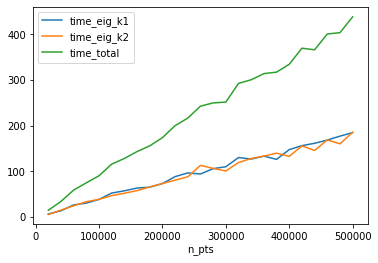

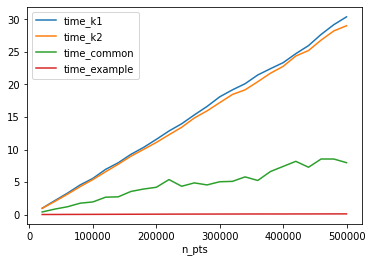

In [11]:
time_data_all["time_total"] =   time_data_all["time_k1"]+ \
                                time_data_all["time_k2"]+ \
                                time_data_all["time_common"]+ \
                                time_data_all["time_example"] +\
                                time_data_all["time_eig_k1"]+\
                                time_data_all["time_eig_k2"]
time_data_all.plot(x="n_pts", y=["time_eig_k1", "time_eig_k2", "time_total"], logy=False)
time_data_all.plot(x="n_pts", y=["time_k1", "time_k2", "time_common",  "time_example"], logy=False)

In [12]:
time_data_all

n_pts  n_kernel_evecs  n_common_evecs  random_seed  time_example  \
0   20000             150              10            0      0.003499   
0   40000             150              10            0      0.009381   
0   60000             150              10            0      0.016111   
0   80000             150              10            0      0.021030   
0  100000             150              10            0      0.026581   
0  120000             150              10            0      0.031842   
0  140000             150              10            0      0.037241   
0  160000             150              10            0      0.043401   
0  180000             150              10            0      0.049008   
0  200000             150              10            0      0.054631   
0  220000             150              10            0      0.061049   
0  240000             150              10            0      0.065561   
0  260000             150              10            0      0.068805   
0  280000             150              10            0      0.071765   
0  300000             150              10            0      0.076205   
0  320000             150              10            0      0.078024   
0  340000             150              10            0      0.082381   
0  360000             150              10            0      0.083849   
0  380000             150              10            0      0.086390   
0  400000             150              10            0      0.082840   
0  420000             150              10            0      0.090903   
0  440000             150              10            0      0.090261   
0  460000             150              10            0      0.093860   
0  480000             150              10            0      0.098251   
0  500000             150              10            0      0.100390   

     time_k1  mat_sparsity_k1  mat_neighbors_per_row_k1    time_k2  \
0   0.971875         0.120765                        24   0.954703   
0   2.142937         0.060504                        24   2.011923   
0   3.295156         0.040347                        24   3.130834   
0   4.556163         0.030281                        24   4.298547   
0   5.560955         0.024224                        24   5.375263   
0   6.942683         0.020205                        24   6.576662   
0   7.963993         0.017319                        24   7.738976   
0   9.259660         0.015151                        24   8.969732   
0  10.327625         0.013472                        24  10.022448   
0  11.559377         0.012126                        24  11.089201   
0  12.847952         0.011024                        24  12.265990   
0  13.960346         0.010108                        24  13.419571   
0  15.324387         0.009330                        24  14.853677   
0  16.621638         0.008665                        24  15.939982   
0  18.104256         0.008088                        24  17.206561   
0  19.174002         0.007583                        24  18.461551   
0  20.119231         0.007135                        24  19.180650   
0  21.463754         0.006739                        24  20.424788   
0  22.430498         0.006384                        24  21.733232   
0  23.356687         0.006066                        24  22.786192   
0  24.740831         0.005778                        24  24.381145   
0  25.979354         0.005516                        24  25.219653   
0  27.708446         0.005276                        24  26.837260   
0  29.203708         0.005056                        24  28.243274   
0  30.406703         0.004854                        24  29.036351   

   mat_sparsity_k2  mat_neighbors_per_row_k2  time_eig_k1  time_eig_k2  \
0         0.121403                        24     6.858528     5.794787   
0         0.060710                        24    14.021348    15.444298   
0         0.040483                        24    26.767954    24.894373   
0         0.03

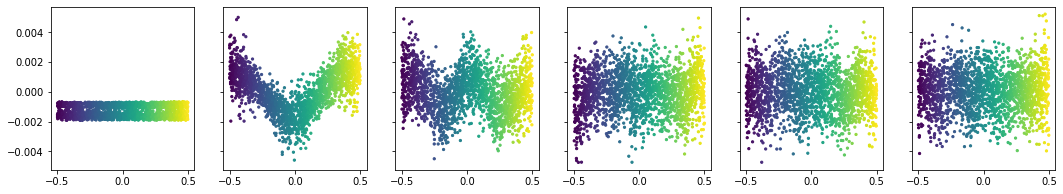

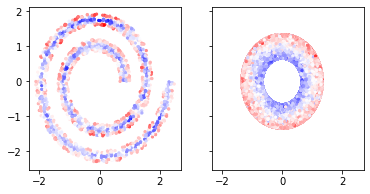

In [16]:
# Cevals, Cevecs = _te.compute_common_system()
_s1, _s2, _peff = _te.setup_example()
n_plots = 6
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*3,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(_peff[idx_plot,].ravel(), Cevecs[idx_plot,k],c=_peff[idx_plot,], s=5)

idx_s2 = _s2[:,2] > 0
fig,ax=plt.subplots(1,2,figsize=(6,3),sharey=True, sharex=True)
ax[0].scatter(*_s1[idx_plot,:].T,c=Cevecs[idx_plot,1], s=m_s, cmap=cmap2);
ax[1].scatter(*_s2[idx_s2,:][:,[0,1]].T,c=Cevecs[idx_s2,1], s=m_s, cmap=cmap2);